In [9]:
import os
import numpy as np
import nibabel as nib
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.utils import to_categorical
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imresize, imrotate
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import models

%matplotlib inline


In [48]:
def preprocess_data_coronal(X,target_height=299,target_width=299, base_slice=64,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[3]
    num_slices = X.shape[2]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def preprocess_data_saggital(X,target_height=299,target_width=299, base_slice=64,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    num_slices = X.shape[3]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def pad_image(image,pad_max):
    if pad_max == 0:
        return image
    else:
        pad_width = np.array([[pad_max,pad_max],[pad_max,pad_max]])-[image.shape,image.shape]
        pad_width=np.transpose(pad_width)
        pad_width[:,0] = np.floor(pad_width[:,0]/2)
        pad_width[:,1] = np.ceil(pad_width[:,1]/2)
        return np.lib.pad(image,pad_width,'constant',constant_values=(0))

In [6]:
#Load in real DWI data
X_header = nib.load('/Users/markgraham/Dropbox/UCL/Projects/QC/deep-qc/data/real/dwi/dwi.nii.gz')
X = X_header.get_data()
X = np.moveaxis(X,3,0)

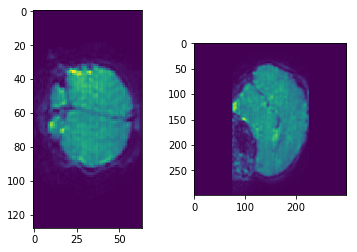

In [49]:
X_test = preprocess_data_saggital(X)

plt.subplot(1,2,1)
plt.imshow(X[0,:,36,:])
plt.subplot(1,2,2)
plt.imshow(X_test[0,:,:,0])

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import models
#from sklearn.model_selection import accuracy

#model_coronal =   models.load_model('keras_logs/coronal_model.hdf5')
model_saggital=   models.load_model('keras_logs/saggital_model.hdf5')

validation_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input,
    data_format='channels_last',)

num_slices = 30
validation_batch_size = 4
num_validation_steps = X_test.shape[0]/validation_batch_size
#model_predictions_coronal = np.zeros((X_test.shape[0],num_slices))
model_predictions_saggital = np.zeros((X_test.shape[0],num_slices))
y_test_fake = np.ones((X_test.shape[0]))

for i in range(num_slices):
    #Coronal
    #X_test_slice = preprocess_data_coronal(X,base_slice = 30+5*i)  
    #Redefine validation generator to reset
    #validation_data_for_testing = validation_generator.flow(X_test_slice,y_test_fake,batch_size=validation_batch_size,shuffle=False)
    #model_predictions_coronal[:,i] = model_coronal.predict_generator(validation_data_for_testing,num_validation_steps)[:,1]
    
    #saggital
    X_test_slice = preprocess_data_saggital(X,base_slice = 35+2*i)  
    #Redefine validation generator to reset
    validation_data_for_testing = validation_generator.flow(X_test_slice,y_test_fake,batch_size=validation_batch_size,shuffle=False)
    model_predictions_saggital[:,i] = model_saggital.predict_generator(validation_data_for_testing,num_validation_steps)[:,1]
    print('Slices complete:',i)

Slices complete: 0
Slices complete: 1
Slices complete: 2
Slices complete: 3
Slices complete: 4
Slices complete: 5
Slices complete: 6
Slices complete: 7
Slices complete: 8
Slices complete: 9


[[ 0.44555935  0.70723516  0.19027214 ...,  0.34434247  0.12613212
   0.05459856]
 [ 0.84576488  0.91017115  0.2193688  ...,  0.04889896  0.05631004
   0.68104839]
 [ 0.01376214  0.01025145  0.01622851 ...,  0.00499185  0.00731137
   0.0115303 ]
 ..., 
 [ 0.16804191  0.67237711  0.58981246 ...,  0.72417063  0.14424749
   0.90044308]
 [ 0.04483622  0.02280879  0.46254218 ...,  0.00346836  0.65170741
   0.09294976]
 [ 0.40041324  0.71426326  0.55037403 ...,  0.61700684  0.62228268
   0.48862857]]


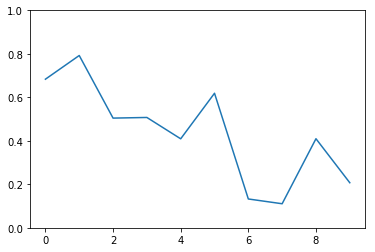

In [118]:
print(model_predictions_saggital)
plt.plot(model_predictions_saggital[151,:])
plt.ylim(0,1)
y_pred_coronal = (np.sum(model_predictions_coronal>0.5,axis=1) > 1)
y_pred_saggital = (np.sum(model_predictions_saggital>0.5,axis=1) > 3)
a=zip(np.linspace(0,171,172),y_pred_saggital)
#list(a)